<a href="https://colab.research.google.com/github/2SEHI/K-Digital_Lecture/blob/main/0809_keras(AutoEncoder/GAN)/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os
from scipy import stats
import seaborn as sns
# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['axes.unicode_minus'] = False
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "generateModel"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
 

font_path = "C:\Windows\Fonts\malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
mpl.rc('font', family=font)

# plt.rc('font', family="malgun.TTF")

import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

## MNIST 가져오기

In [ ]:
### 데이터 생성
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
    
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)


(55000, 28, 28)
(5000, 28, 28)
(55000,)
(5000,)


In [ ]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
def show_reconstructions(model, images=X_valid, n_images=5):
    #재구성된 이미지 데이터
    recounstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plot_image(images[image_index])
        
        plt.subplot(2, n_images, 1+n_images + image_index)
        plot_image(recounstructions[image_index])


## Anto Encoder
- 입력데이터를 가지고 다시 새로운 입력 데이터를 생성하는 모델입니다. 생성모델이라고 많이 부릅니다.

1) 1개층을 이용한  AutoEncoder는 PCA효과를 만들 수 있습니다.
2) Stacked Auto Encoder(Deep Auto Encoder - 적층 오토 인코더) : 은닉층을 여러개 쌓은 Auto Encoder입니다.
3) Confolutional Auto Encoder(합성곱 오토 인코더)
- 이미지를 다루는 경우에는 이미지가 매우 작지 않다면 오토 인코더가 좋은 성능을 내지 못합니다.
- 이미지를 다룰 때는 합성곱 신경망(CNN)이 밀집 네트워크(Dense 층)보다 훨씬 잘 맞는데 비지도 사전훈련이나 차원 축소를 위해서 이미지에 대한 오토 인코더를 만들 때도 합성곱 신경망을 이용하는 것이 졸은 성능을 만드는 경우가 많습니다.
- 인코더는 합성곱층과 풀링 층으로 구성된 CNN이고 인코더는 입력해서 공간 방향의 차원을 줄이고(높이와 너비를 줄임) 깊이를 늘림(특성 맵의 개수를 늘림)
- 디코더는 이미지의 스케일을 늘리고 깊이를 원본 차원으로 되돌려야 하는데 이를 위해서 전치 합성곱 층을 사용합니다.

## 합성곱 오토 인코더

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

### 인코더를 생성

In [ ]:
conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]), 
    # 합성곱층
    keras.layers.Conv2D(16, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    
    # 몇 개의 층을 더 생성
    # 합성곱은 점차 늘어납니다.
    keras.layers.Conv2D(32, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding='SAME', activation='selu'),
    keras.layers.MaxPool2D(pool_size=2),
])

### 디코더 생성
- 인코더의 순서에 유의하며 작성합니다.

In [ ]:
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2,
        ## input_shape와 마지막 인코더가 맞아야 합니다.
        padding='VALID',activation='selu',input_shape = [3, 3, 64]),

    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2,
        ## input_shape와 마지막 인코더가 맞아야 합니다.
        padding='SAME',activation='selu'), 

    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2,
    ## input_shape와 마지막 인코더가 맞아야 합니다.
    padding='SAME',activation='sigmoid'),
    keras.layers.Reshape([28, 28])
    
])

## 합성곱 오토 인코더를 생성하고 훈련
합성곱 의 val_accuracy 성능을 확인해봐야 합니다.

In [ ]:
conv_ae = keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.SGD(lr=1.0),
               metrics=['accuracy'])
history = conv_ae.fit(X_train, X_train, epochs=5,
                     validation_data = (X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.3018 - accuracy: 0.1670 - val_loss: 0.2844 - val_accuracy: 0.1998
Epoch 2/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.2756 - accuracy: 0.2201 - val_loss: 0.2729 - val_accuracy: 0.2377
Epoch 3/5
1719/1719 [==============================] - 21s 12ms/step - loss: 0.2708 - accuracy: 0.2471 - val_loss: 0.2696 - val_accuracy: 0.2546
Epoch 4/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2682 - accuracy: 0.2632 - val_loss: 0.2685 - val_accuracy: 0.2753
Epoch 5/5
1719/1719 [==============================] - 22s 13ms/step - loss: 0.2664 - accuracy: 0.2746 - val_loss: 0.2672 - val_accuracy: 0.2909


## 생성한 이미지 출력

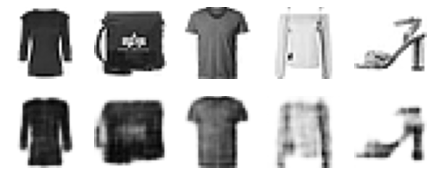

In [ ]:
show_reconstructions(conv_ae)
plt.show()

## Recurrent Auto Encoder(순환 오토 인코더) : Simple RNN(제일 떨어짐), 대부분 LSTM사용,
- 이미지에 있어서 CNN보다 좋은 성능을 나타내지는 못합ㄴ다
- 비지도 학습이나 차원 숙소를 위해 시계열이나 테스트와 같은 시퀀스에 대한 오토 인코더를 만들 때는 순환 신경망이 밀밀집 네트워크 보다 더 나을 수 있습니다.
- 인코더는 입력 시퀀스를 하나의 벡터로 압축하는 시권스 투 벡터 RNN을 이용하고 디코더는 반대로 벡터 투 시퀀스 RNN을 이용합니다.
- RNN이 그닥 효과가 없습니다.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

### 인코더를 생성

In [ ]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[28, 28]),
    # RNN에서는 계속 넘겨주어야 하는데 마지막꺼는 쓸 필요 없습니다.
    keras.layers.LSTM(30)
])

### 디코더를 생성

In [ ]:
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])

### 순환 오토 인코더를 생성하고 훈련

In [ ]:
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=['accuracy'])

history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))


Epoch 1/10
1719/1719 [==============================] - 47s 26ms/step - loss: 0.5019 - accuracy: 0.0444 - val_loss: 0.4505 - val_accuracy: 0.0477
Epoch 2/10
1719/1719 [==============================] - 44s 25ms/step - loss: 0.4008 - accuracy: 0.0472 - val_loss: 0.3759 - val_accuracy: 0.0539
Epoch 3/10
1719/1719 [==============================] - 38s 22ms/step - loss: 0.3677 - accuracy: 0.0590 - val_loss: 0.3609 - val_accuracy: 0.0664
Epoch 4/10
1719/1719 [==============================] - 41s 24ms/step - loss: 0.3531 - accuracy: 0.0695 - val_loss: 0.3586 - val_accuracy: 0.0691
Epoch 5/10
1719/1719 [==============================] - 46s 27ms/step - loss: 0.3430 - accuracy: 0.0736 - val_loss: 0.3382 - val_accuracy: 0.0726
Epoch 6/10
1719/1719 [==============================] - 42s 25ms/step - loss: 0.3355 - accuracy: 0.0747 - val_loss: 0.3321 - val_accuracy: 0.0743
Epoch 7/10
1719/1719 [==============================] - 37s 22ms/step - loss: 0.3299 - accuracy: 0.0750 - val_loss: 0.3311 -

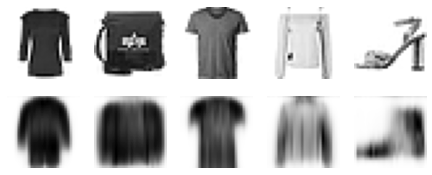

In [ ]:
show_reconstructions(recurrent_ae)
plt.show()

## 잡음 제거 오토 인코더
- 입력에 잡음을 추가하고 잡음이 없는 원본 입력을 복원하도록 해서 유용한 특성을 학습하도록 강제하는 것
- 잡음으로는 가우시안 잡음이나 무작위 드롭아웃을 사용합니다.
    - 가우시안 잡음 제거: 정규분포
    - 드롭아웃 : 일정 부분을 무작위로 제거
    



### 가우시안 잡음을 추가한 오토 인코더
- 잡음을 넣은 사진을 필터링하기

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4769 - accuracy: 0.0484 - val_loss: 0.3835 - val_accuracy: 0.0558
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3700 - accuracy: 0.0594 - val_loss: 0.3633 - val_accuracy: 0.0611
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3546 - accuracy: 0.0683 - val_loss: 0.3482 - val_accuracy: 0.0751
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3410 - accuracy: 0.0781 - val_loss: 0.3362 - val_accuracy: 0.0798
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3314 - accuracy: 0.0817 - val_loss: 0.3286 - val_accuracy: 0.0832
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3255 - accuracy: 0.0856 - val_loss: 0.3237 - val_accuracy: 0.0890
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3217 - accuracy: 0.0895 - val_loss: 0.3205 - val_accuracy:

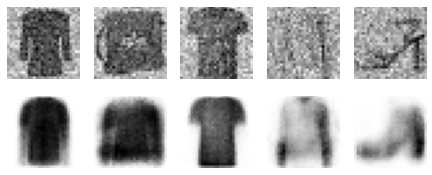

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

# 잡음 적층 인코더 생성
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),# add를 이용해도 됩니다.
    keras.layers.GaussianNoise(0.2),# 노이즈 삽입
    keras.layers.Dense(100, activation='selu'),# 일반 적측 생성
    # 합성곱과 헷갈리면 안됩니다. 뉴런의 개수는 줄어들어야 합니다.
    keras.layers.Dense(30, activation='selu')
])

# 디코더 생성
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])



# 오토 인코더를 생성하고 훈련
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=['accuracy'])

history = denoising_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

# 잡음 추가한 이미지를 확인하기 위해 잡음 추가
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

### 드랍 아웃 추가

Epoch 1/10
1719/1719 [==============================] - 5s 2ms/step - loss: 0.4866 - accuracy: 0.0472 - val_loss: 0.3897 - val_accuracy: 0.0532
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3755 - accuracy: 0.0579 - val_loss: 0.3661 - val_accuracy: 0.0592
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3616 - accuracy: 0.0640 - val_loss: 0.3547 - val_accuracy: 0.0712
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3503 - accuracy: 0.0738 - val_loss: 0.3425 - val_accuracy: 0.0784
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3397 - accuracy: 0.0798 - val_loss: 0.3328 - val_accuracy: 0.0812
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3324 - accuracy: 0.0838 - val_loss: 0.3267 - val_accuracy: 0.0879
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3279 - accuracy: 0.0873 - val_loss: 0.3231 - val_accuracy:

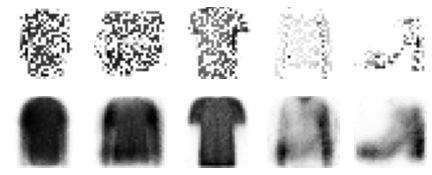

In [ ]:
# 동일한 결과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

#드랍아웃 적층 인코더
dropout_encoder = keras.models.Sequential([
   keras.layers.Flatten(input_shape=[28,28]),
   keras.layers.Dropout(0.5),
   keras.layers.Dense(100, activation='selu'),
   keras.layers.Dense(30, activation='selu')     
])

dropout_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[30]),
    keras.layers.Dense(28*28, activation='sigmoid'),
    keras.layers.Reshape([28,28])
])

dropout_ae = keras.models.Sequential([dropout_encoder, 
                                        dropout_decoder])

dropout_ae.compile(loss = 'binary_crossentropy',
                     optimizer = keras.optimizers.SGD(0.1),
                    metrics=['accuracy'])

history = dropout_ae.fit(X_train, X_train, epochs=10, 
                           validation_data=(X_valid, X_valid))

#이미지에서 일정 부분을 제거하기 위해서 Dropout을 추가
dropout = keras.layers.Dropout(0.5)
show_reconstructions(dropout_ae, dropout(X_valid, training=True))
plt.show()

## L1 규제를 추가한 희소 오토 인코더

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5813 - accuracy: 0.0442 - val_loss: 0.5089 - val_accuracy: 0.0439
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4913 - accuracy: 0.0450 - val_loss: 0.4791 - val_accuracy: 0.0438
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4591 - accuracy: 0.0451 - val_loss: 0.4424 - val_accuracy: 0.0445
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4270 - accuracy: 0.0482 - val_loss: 0.4187 - val_accuracy: 0.0485
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4091 - accuracy: 0.0505 - val_loss: 0.4052 - val_accuracy: 0.0501
Epoch 6/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3982 - accuracy: 0.0522 - val_loss: 0.3963 - val_accuracy: 0.0521
Epoch 7/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3905 - accuracy: 0.0536 - val_loss: 0.3899 - val_accuracy:

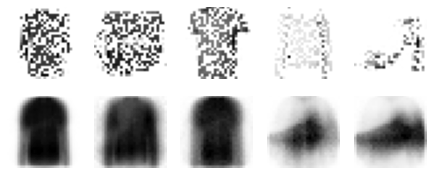

In [ ]:
# 동일한 결과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

#L1 규제를 추가한 적층 인코더
sparse_l1_encoder = keras.models.Sequential([
   keras.layers.Flatten(input_shape=[28 , 28]),
   keras.layers.Dense(100, activation='selu'),
   keras.layers.Dense(300, activation='sigmoid'),
   keras.layers.ActivityRegularization(l1 = 1e-3)
])

sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation='selu', input_shape=[300]),
    keras.layers.Dense(28 * 28, activation='sigmoid'),
    keras.layers.Reshape([28 , 28])
])

sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, 
                                        sparse_l1_decoder])

sparse_l1_ae.compile(loss = 'binary_crossentropy',
                     optimizer = keras.optimizers.SGD(0.1),
                    metrics=['accuracy'])

history = sparse_l1_ae.fit(X_train, X_train, epochs=10, 
                           validation_data=(X_valid, X_valid))


show_reconstructions(sparse_l1_ae, dropout(X_valid, training=True))
plt.show()

## 패션 MNIST 에 VAE를 적용

### 샘플링을 위한 클래스

In [ ]:
#케라스의 연산 함수를 줄였쓰기 위해서 작성
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        #평균 과 표준편차 찾아오기
        mean, log_var = inputs
        #K.random_normal 함수를 이용해서 평균이 0이고 표준 편차가 1인
        #정규분포를 만들고 데이터를 생성하기 위해서 
        #지수 함수를 곱하고 평균을 더함
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
        

### 모델 생성 과 훈련

In [ ]:
# 동일한 결과를 만들기 위한 설정
tf.random.set_seed(42)
np.random.seed(42)

#함수형 API를 이용해서 모델을 생성
coding_size = 10

#입력 층 생성
inputs = keras.layers.Input(shape=[28,28])
#1차원으로 펼치기
z = keras.layers.Flatten()(inputs)
#밀집 네트워크 생성
z = keras.layers.Dense(150, activation='selu')(z)
z = keras.layers.Dense(100, activation='selu')(z)

#mean 과 log_var 을 생성
#10가지로 분류되기 때문에 coding_size 를 10으로 설정
codings_mean = keras.layers.Dense(coding_size)(z)
codings_log_var = keras.layers.Dense(coding_size)(z)

#샘플링 층 생성
codings = Sampling()([codings_mean, codings_log_var])

#인코더 생성
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs = [codings_mean, codings_log_var, codings]
)


#디코더 생성
decoder_inputs = keras.layers.Input(shape=[coding_size])
#밀집 네트워크 생성
x = keras.layers.Dense(100, activation='selu')(decoder_inputs)
x = keras.layers.Dense(150, activation='selu')(x)
x = keras.layers.Dense(28*28, activation='sigmoid')(x)
outputs = keras.layers.Reshape([28,28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], 
                                        outputs=[outputs])

#인코더 와 디코더를 이용해서 모델을 생성
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

variational_ae = keras.models.Model(inputs=[inputs],
                                    outputs=[reconstructions])

#잠재 손실 과 재구성 손실을 추가
latent_loss = -0.5 * K.sum(1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean), axis=-1)

#784는  28 * 28
variational_ae.add_loss(K.mean(latent_loss) / 784)



#모델 훈련
variational_ae.compile(loss = 'binary_crossentropy',
                     optimizer = "rmsprop",
                    metrics=['accuracy'])

history = variational_ae.fit(X_train, X_train, epochs=25,
                             batch_size=128,
                           validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 3s 6ms/step - loss: 0.3894 - accuracy: 0.0751 - val_loss: 0.3533 - val_accuracy: 0.0961
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3424 - accuracy: 0.0929 - val_loss: 0.3348 - val_accuracy: 0.0952
Epoch 3/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3327 - accuracy: 0.1011 - val_loss: 0.3299 - val_accuracy: 0.1010
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3279 - accuracy: 0.1083 - val_loss: 0.3300 - val_accuracy: 0.1107
Epoch 5/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3248 - accuracy: 0.1132 - val_loss: 0.3271 - val_accuracy: 0.1098
Epoch 6/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3226 - accuracy: 0.1181 - val_loss: 0.3259 - val_accuracy: 0.1118
Epoch 7/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3210 - accuracy: 0.1222 - val_loss: 0.3279 - val_accuracy: 0.1229
Epoch 

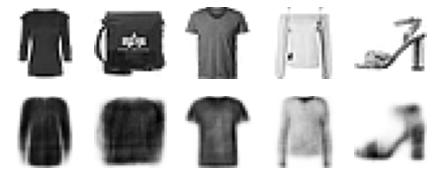

In [ ]:
show_reconstructions(variational_ae)
plt.show()

### 새로운 이미지 생성

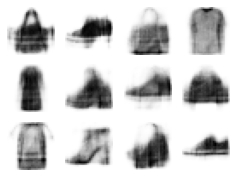

In [ ]:
#샘플을 출력하기 위한 함수
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images)-1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis = -1)
    
    plt.figure(figsize = (n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')
        

#샘플 이미지 생성
tf.random.set_seed(42)
codings = tf.random.normal(shape=[12, 10])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)